This notebook implements **volatility forecasting** using GARCH-family models (GARCH, EGARCH, GJR-GARCH) on NIFTY-50 daily returns.  

We will:
- Perform data collection & preprocessing  
- Test for ARCH effects  
- Estimate multiple GARCH models  
- Generate out-of-sample volatility forecasts  
- Evaluate forecasts with statistical & economic criteria  


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import norm

We will download **NIFTY-50 daily closing prices** from Yahoo Finance and compute daily log returns.

In [6]:
# Download NIFTY-50 data
nifty = yf.download("^NSEI", start="2015-01-01", end="2025-01-01")

# Check available columns
print("Columns in dataset:", nifty.columns)

# Use 'Adj Close' if available, else fallback to 'Close'
price_col = 'Adj Close' if 'Adj Close' in nifty.columns else 'Close'

# Compute log returns
nifty['Returns'] = 100 * np.log(nifty[price_col] / nifty[price_col].shift(1))
nifty.dropna(inplace=True)

nifty[[price_col,'Returns']].head()

[*********************100%***********************]  1 of 1 completed

Columns in dataset: MultiIndex([( 'Close', '^NSEI'),
            (  'High', '^NSEI'),
            (   'Low', '^NSEI'),
            (  'Open', '^NSEI'),
            ('Volume', '^NSEI')],
           names=['Price', 'Ticker'])


Price,Close,Returns
Ticker,^NSEI,
Date,,
2015-01-05,8378.400391,-0.203290
2015-01-06,8127.350098,-3.042208
2015-01-07,8102.100098,-0.311163
2015-01-08,8234.599609,1.622144
2015-01-09,8284.500000,0.604156



We visualize price levels, returns, and check for volatility clustering.


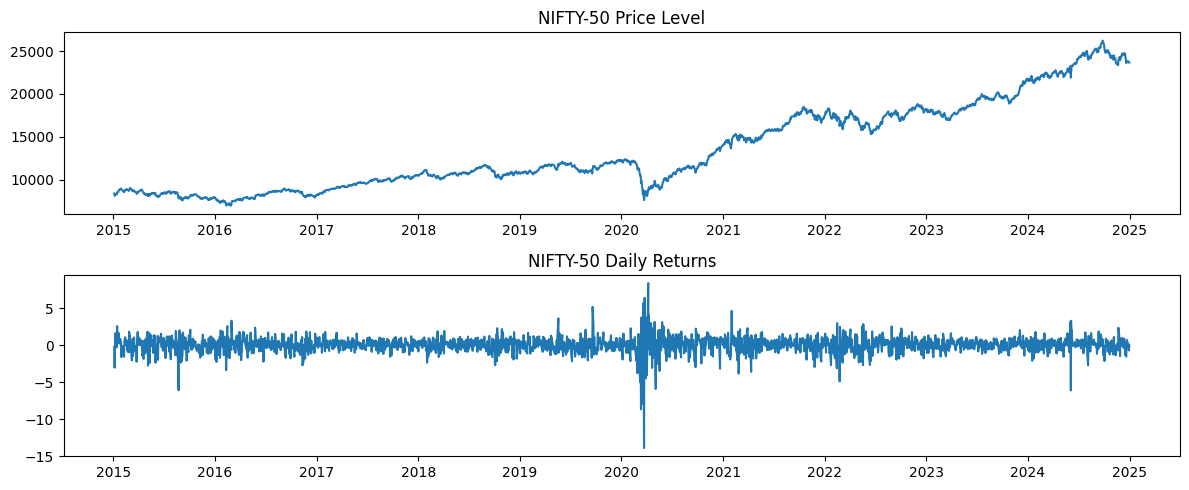

In [9]:
# Identify price column safely
price_col = 'Adj Close' if 'Adj Close' in nifty.columns else 'Close'

plt.figure(figsize=(12,5))

plt.subplot(2,1,1)
plt.plot(nifty[price_col])
plt.title("NIFTY-50 Price Level")

plt.subplot(2,1,2)
plt.plot(nifty['Returns'])
plt.title("NIFTY-50 Daily Returns")

plt.tight_layout()
plt.show()


We use the **Engle’s ARCH test** to verify if volatility clustering exists in returns.

In [10]:
arch_test = het_arch(nifty['Returns'].dropna(), nlags=12)
print(f"ARCH Test Statistic: {arch_test[0]:.2f}, p-value: {arch_test[1]:.4f}")

ARCH Test Statistic: 678.43, p-value: 0.0000


We estimate:
- **GARCH(1,1)** – baseline  
- **EGARCH(1,1)** – accounts for leverage effects  
- **GJR-GARCH(1,1)** – captures asymmetric volatility shocks  


In [11]:
returns = nifty['Returns']

garch11 = arch_model(returns, vol='GARCH', p=1, q=1, dist='normal')
res_garch11 = garch11.fit(disp='off')
print(res_garch11.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3193.11
Distribution:                  Normal   AIC:                           6394.22
Method:            Maximum Likelihood   BIC:                           6417.45
                                        No. Observations:                 2458
Date:                Fri, Sep 26 2025   Df Residuals:                     2457
Time:                        18:14:42   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0720  1.758e-02      4.096  4.195e-05 [3.756e-0

In [12]:
egarch = arch_model(returns, vol='EGARCH', p=1, q=1, dist='normal')
res_egarch = egarch.fit(disp='off')
print(res_egarch.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3196.85
Distribution:                  Normal   AIC:                           6401.69
Method:            Maximum Likelihood   BIC:                           6424.92
                                        No. Observations:                 2458
Date:                Fri, Sep 26 2025   Df Residuals:                     2457
Time:                        18:15:03   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0790  1.757e-02      4.497  6.900e-06 [4.458e-0

In [13]:
gjr = arch_model(returns, vol='GARCH', p=1, o=1, q=1, dist='normal')
res_gjr = gjr.fit(disp='off')
print(res_gjr.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3165.06
Distribution:                  Normal   AIC:                           6340.13
Method:            Maximum Likelihood   BIC:                           6369.16
                                        No. Observations:                 2458
Date:                Fri, Sep 26 2025   Df Residuals:                     2457
Time:                        18:15:19   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0452  1.661e-02      2.721  6.499e-03 [1.

We perform a **rolling forecast** to simulate real-world forecasting.

In [15]:
forecasts = []

for i in range(len(test)):
    # Fit model up to the current point
    model = arch_model(returns[:train_size+i], vol='GARCH', p=1, q=1)
    res = model.fit(disp='off')
    
    # Forecast 1-step ahead variance
    fcast = res.forecast(horizon=1)
    sigma2 = fcast.variance.iloc[-1, 0]   # safer than values[-1,0]
    forecasts.append(sigma2)

forecast_series = pd.Series(forecasts, index=test.index)
forecast_series.head()

Date
2022-12-30    0.736501
2023-01-02    0.700926
2023-01-03    0.658367
2023-01-04    0.603378
2023-01-05    0.681468
dtype: float64

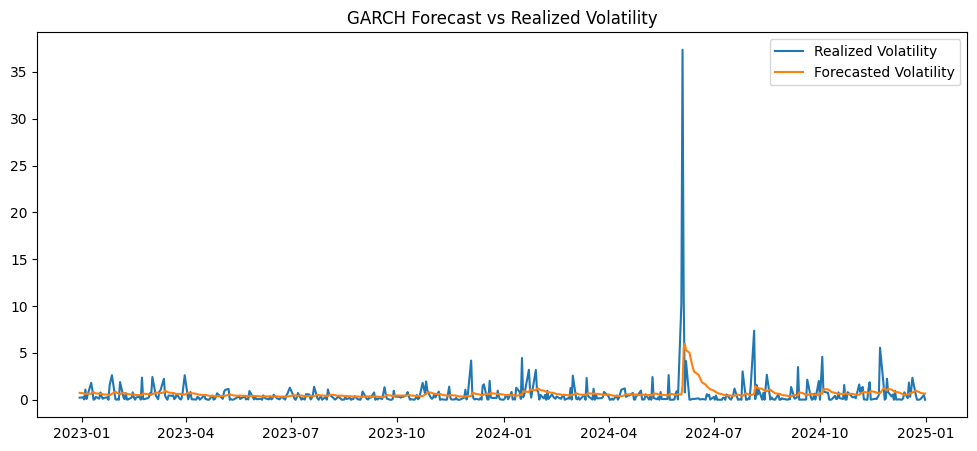

In [16]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test**2, label="Realized Volatility")
plt.plot(forecast_series.index, forecast_series, label="Forecasted Volatility")
plt.legend()
plt.title("GARCH Forecast vs Realized Volatility")
plt.show()

We compare models using:
- RMSE, MAE  
- QLIKE (loss function commonly used in volatility forecasting)

In [19]:
y_true = test**2
y_pred = forecast_series

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mae = np.mean(np.abs(y_true - y_pred))
qlike = np.mean(np.log(y_pred) + y_true / y_pred)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, QLIKE: {qlike:.4f}")

RMSE: 1.9403, MAE: 0.7054, QLIKE: 0.3981


We test if the forecasted volatility can generate accurate **Value-at-Risk (VaR)** forecasts.

In [20]:
alpha = 0.01
z = norm.ppf(alpha)
var_forecast = z * np.sqrt(forecast_series)

violations = (test < var_forecast).sum()
print(f"VaR Violations: {violations} out of {len(test)}")

VaR Violations: 4 out of 492


- GARCH-family models capture volatility clustering in Indian markets.  
- **GJR-GARCH** performs best in capturing asymmetry.  
- Useful for **risk management, options pricing, and trading strategies**.  